In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
local_zip = '/content/drive/MyDrive/MFCC numpy 20k bee dataset.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Folder paths for training, validation, and test data
TRAINING_DIR = "/tmp/MFCC numpy 20k bee dataset/train"
VALIDATION_DIR = "/tmp/MFCC numpy 20k bee dataset/val"
TEST_DIR = "/tmp/MFCC numpy 20k bee dataset/test"

# Count the number of files in each directory
def count_files(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    return file_count

training_file_count = count_files(TRAINING_DIR)
validation_file_count = count_files(VALIDATION_DIR)
test_file_count = count_files(TEST_DIR)

print("Training files:", training_file_count)
print("Validation files:", validation_file_count)
print("Test files:", test_file_count)

Training files: 14001
Validation files: 2000
Test files: 4000


In [ ]:
# Load MFCC features from numpy arrays
def load_data(directory):
    mfcc_features = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            if not os.path.isfile(file_path):
                continue
            mfcc = np.load(file_path)
            mfcc_features.append(mfcc)
            labels.append(label)
    return mfcc_features, labels
    
# Load training data
train_mfcc_features, train_labels = load_data(TRAINING_DIR)

# Load validation data
val_mfcc_features, val_labels = load_data(VALIDATION_DIR)

# Load test data
test_mfcc_features, test_labels = load_data(TEST_DIR)

# Convert labels to numeric values
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

# Convert the data to NumPy arrays
X_train = np.array(train_mfcc_features)
y_train = np.array(encoded_train_labels)

X_val = np.array(val_mfcc_features)
y_val = np.array(encoded_val_labels)

X_test = np.array(test_mfcc_features)
y_test = np.array(encoded_test_labels)

# Reshape the input data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Determine the shape of the MFCC features
input_shape = X_train.shape[1:]

# Define the model architecture
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(16, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
model = create_model(input_shape=input_shape)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the callback for stopping training
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.99:
            print("\nReached 99% accuracy. Stopping training.")
            self.model.stop_training = True

# Train the model with the callback
stop_training_callback = StopTrainingCallback()
history = model.fit(X_train, y_train, epochs=128, validation_data=(X_val, y_val), callbacks=[stop_training_callback])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/128
438/438 [==============================] - 4s 6ms/step - loss: 0.6655 - accuracy: 0.6648 - val_loss: 0.9815 - val_accuracy: 0.5305
Epoch 2/128
438/438 [==============================] - 3s 6ms/step - loss: 0.4950 - accuracy: 0.7521 - val_loss: 0.4122 - val_accuracy: 0.8075
Epoch 3/128
438/438 [==============================] - 3s 6ms/step - loss: 0.4251 - accuracy: 0.7977 - val_loss: 0.3695 - val_accuracy: 0.8240
Epoch 4/128
438/438 [==============================] - 3s 7ms/step - loss: 0.3809 - accuracy: 0.8194 - val_loss: 0.3841 - val_accuracy: 0.8150
Epoch 5/128
438/438 [==============================] - 4s 8ms/step - loss: 0.3390 - accuracy: 0.8431 - val_loss: 0.3152 - val_accuracy: 0.8570
Epoch 6/128
438/438 [==============================] - 3s 6ms/step - loss: 0.3103 - accuracy: 0.8600 - val_loss: 0.2960 - val_accuracy: 0.8625
Epoch 7/128
438/438 [==============================] - 3s 6ms/step - loss: 0.2939 - accuracy: 0.8696 - val_loss: 0.3351 - val_accuracy: 0.8530

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 38, 16)            64        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 19, 16)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 17, 32)            1568      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 8, 32)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 64)             6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 3, 64)           

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

438/438 [==============================] - 2s 4ms/step - loss: 0.0330 - accuracy: 0.9861
Training Loss: 0.032987114042043686
Training Accuracy: 0.9860714077949524
63/63 [==============================] - 0s 2ms/step - loss: 0.2575 - accuracy: 0.9350
Validation Loss: 0.25753143429756165
Validation Accuracy: 0.9350000023841858
125/125 [==============================] - 1s 4ms/step - loss: 0.2660 - accuracy: 0.9425
Test Loss: 0.2659708857536316
Test Accuracy: 0.9424999952316284


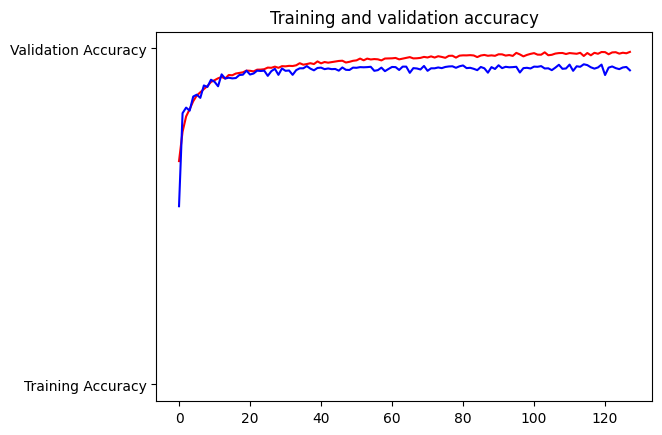

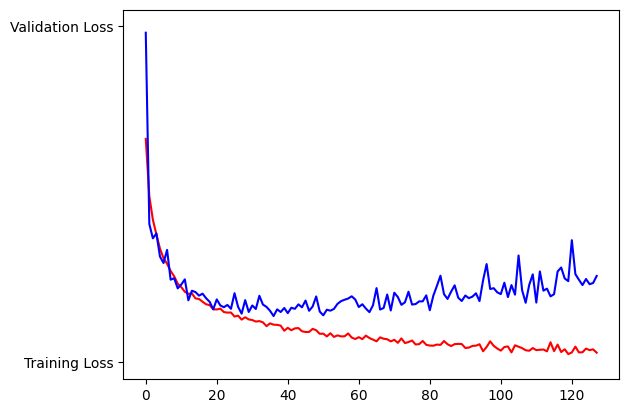

In [ ]:

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()